# Random Walks en Multiplex de Aerolíneas

## Directorio

In [1]:
#Establecer directorio
cd("$(homedir())/Documents/UNAM/Tesis_Lic")

## Paquetes

Se importan todos los paquetes que se necesitarán para las funciones y visualizaciones del proyecto.

In [2]:
using StatsBase

#using NamedArrays
#using CSV
#using DataFrames

In [3]:
using DelimitedFiles

In [4]:
using RandomNumbers.Xorshifts

In [5]:
using LightGraphs

In [6]:
using Plots

In [7]:
using GraphPlot

In [157]:
using Compose

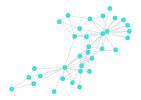

In [158]:
g = graphfamous("karate")
gplot(g)

In [159]:
draw(PNG("karate.png", 16cm, 16cm), gplot(g))

ErrorException: The Cairo and Fontconfig packages are necessary for saving as PNG.
Add them with the package manager if necessary, then run:
  import Cairo, Fontconfig
before invoking PNG.


In [6]:
dicc_global = airport_names("data/multi_17_du.csv") #Nombres de aeropuertos globales

UndefVarError: UndefVarError: airport_names not defined

In [7]:
num_global = collect(1:length(dicc_global));

UndefVarError: UndefVarError: dicc_global not defined

In [8]:
glob = hcat(dicc_global, num_global);

UndefVarError: UndefVarError: dicc_global not defined

In [9]:
glob;

UndefVarError: UndefVarError: glob not defined

In [10]:
a_2b = airport_names("data/aerolineas_matrices/2B_matriz_du.csv");
na_2b = hcat(a_2b, collect(1:length(a_2b)));

UndefVarError: UndefVarError: airport_names not defined

In [11]:
#glob[1,:]
#for i in 1:length(na_2b)
    #hh = hcat(glob[1,:], na_2b[1,:])
    #push!(glob, hh)
#end
#return hh

In [12]:
#for i in 1:length(a_2b)
#    glob

In [13]:
#glob[1,:]

In [14]:
typeof(dicc_global[1]) #Cada entrada de la lista de aeropuertos

UndefVarError: UndefVarError: dicc_global not defined

In [15]:
size(caminata_M[1])

UndefVarError: UndefVarError: caminata_M not defined

In [16]:
m_cero[1,3]

UndefVarError: UndefVarError: m_cero not defined

In [17]:
###### airport_names("data/aerolineas_matrices/$aerolinea_matriz")

In [18]:
m_cero2

UndefVarError: UndefVarError: m_cero2 not defined

In [19]:
mat2b = import_matrix("data/aerolineas_matrices/2B_matriz_du.csv");

UndefVarError: UndefVarError: import_matrix not defined

In [20]:
rw2b = random_walk(mat2b, 5, 2);
rw2b[1]

UndefVarError: UndefVarError: random_walk not defined

In [21]:
walk_names(rw2b, "2B", 1)

UndefVarError: UndefVarError: walk_names not defined

In [22]:
walk_names(rw2b, "2B", 3)

UndefVarError: UndefVarError: walk_names not defined

In [23]:
walk_global(rw2b, "2B", 1)

UndefVarError: UndefVarError: walk_global not defined

In [24]:
walk_global(rw2b, "2B", 2)

UndefVarError: UndefVarError: walk_global not defined

In [25]:
vv2b = visited_vertices(rw2b)
vv2b[1][1,:] #Nodos únicos visitados en la iteración 1 con nodo inicial 1

UndefVarError: UndefVarError: visited_vertices not defined

In [26]:
posiciones = findall(x -> x == 17, rw2b[1][1,:]) #Busco en la caminata 1 con nodo inicial 1 el nodo 17
#Me da como resultado 4 y 6 que corresponde a las posiciones

UndefVarError: UndefVarError: rw2b not defined

In [27]:
hhh = findall(x -> x == "2B_num", archivo_dicc)

UndefVarError: UndefVarError: archivo_dicc not defined

In [28]:
hhh[1][2]

UndefVarError: UndefVarError: hhh not defined

In [29]:
typeof(posiciones)

UndefVarError: UndefVarError: posiciones not defined

In [30]:
######### Prueba ejemplo 

#Primero obtenemos la caminata aleatoria para un sólo nodo. 
#Leemos el archivo con la caminata 2B_1_random_walk.csv

archivo_rwalk = readdlm("/Users/yuriko/Downloads/codejulia/data/2B/caminatas/2B_1_random_walk.csv", ',', Int64) 
#Al leer el archivo convierte los números a flotantes

2×6 Array{Int64,2}:
 1  8  4  17  12  17
 1  8  1   8   5   8

In [31]:
vv2b[1]

UndefVarError: UndefVarError: vv2b not defined

In [32]:
#Leo archivo de diccionario final
archivo_dicc = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/data/diccionarios/dictionary_final.csv", ',') 

3190×570 Array{Any,2}:
     ""  "global_airports"  …  "ZK_num"  "ZL_num"   "ZM_num"
    1    "AER"                 "NA"      "NA"       "NA"    
    2    "ASF"                 "NA"      "NA"       "NA"    
    3    "CEK"                 "NA"      "NA"       "NA"    
    4    "DME"                 "NA"      "NA"      1        
    5    "EGO"              …  "NA"      "NA"       "NA"    
    6    "GYD"                 "NA"      "NA"       "NA"    
    7    "KGD"                 "NA"      "NA"       "NA"    
    8    "KZN"                 "NA"      "NA"       "NA"    
    9    "LED"                 "NA"      "NA"       "NA"    
   10    "MRV"              …  "NA"      "NA"       "NA"    
   11    "NBC"                 "NA"      "NA"       "NA"    
   12    "NJC"                 "NA"      "NA"       "NA"    
    ⋮                       ⋱                               
 3178    "LPS"                 "NA"      "NA"       "NA"    
 3179    "ORX"                 "NA"      "NA"       "NA"    
 

In [33]:
archivo_dicc[:,4] #columna 3

3190-element Array{Any,1}:
   "2B_num"
  1        
  2        
  3        
  4        
  5        
  6        
  7        
  8        
  9        
 10        
 11        
 12        
  ⋮        
   "NA"    
   "NA"    
   "NA"    
   "NA"    
   "NA"    
   "NA"    
   "NA"    
   "NA"    
   "NA"    
   "NA"    
   "NA"    
   "NA"    

In [34]:
nt = Array{Union{Nothing, String}}(nothing, 2, 6)

2×6 Array{Union{Nothing, String},2}:
 nothing  nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing  nothing

In [35]:
nt[1,1] = "hola"
nt

2×6 Array{Union{Nothing, String},2}:
 "hola"   nothing  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  nothing  nothing

In [36]:
typeof(archivo_dicc[3191])
#archivo_dicc[3191]
archivo_dicc[1,2]

"global_airports"

In [37]:
typeof(archivo_dicc)

Array{Any,2}

In [38]:
ijf = "2B_num"
#x -> archivo_dicc[:, x == ijf]

"2B_num"

In [39]:
kjg=findall(x -> x==ijf, archivo_dicc)

1-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 4)

In [40]:
kjg[1][2]

4

In [41]:
archivo_dicc[1,4]

"2B_num"

In [42]:
m_cero2[5,25]

UndefVarError: UndefVarError: m_cero2 not defined

In [43]:
#for i in 1:length(caminata_M[1])
    

## Funciones

### Importar datos

In [8]:
"""
    import_matrix(arch::AbstractString)

Función que importa el archivo de la matriz de adyacencia de R.
"""
function import_matrix(arch::AbstractString)
    archivo_R = readdlm(arch, ',') 
    archivo_R = archivo_R[2:end, :]
    matriz = archivo_R[:, 2:end]
    nombre = convert(Array{Int64,2}, matriz)
    return nombre
end

import_matrix

### Nombres de datos

In [9]:
"""
    airport_names(arch::AbstractString)

Función que obtiene un arreglo con los nombres de aeropuertos de la matriz
"""
function airport_names(arch::AbstractString)
    archivo_R = readdlm(arch, ',', String)
    columna = archivo_R[1, :]
    nombres = columna[2:end]
    return nombres
end

airport_names

### Grado

In [10]:
"""

    n_in_degree(M::Array{Int64,2}, n::Int64)

Función que obtiene el grado de entrada de un cierto nodo n de la red representada por la matriz de adyacencia M.

Parámetros:
M matriz de adyacencia que acepta un arreglo de tipo Array{Int64,2}
n nodo a evaluar de tipo Int64

Resultado:
Grado de entrada del nodo n representado por un valor numérico de tipo Int64

Implementación

#### Ejemplos
"""
function n_in_degree(M::Array{Int64,2}, n::Int64)
    grado_entrada = sum(M[n, :])
end

n_in_degree

In [11]:
"""
    in_degree(M::Array{Int64,2})

Función que obtiene el grado de entrada de una red representada por la matriz de adyacencia M.

Parámetros:
* M matriz de adyacencia que acepta un arreglo de tipo Array{Int64,2}

Resultado:
Devuelve un arreglo de tipo Array{Int64,2} que contiene los grados de entrada de todos los nodos n de la red.

## Implementación

### Ejemplos
"""
function in_degree(M::Array{Int64,2})
    grados_entrada = sum(M, dims = 2)
end

in_degree

In [12]:
"""
    n_out_degree(M::Array{Int64,2}, n::Int64)

Función que obtiene el grado de salida de un cierto nodo n de la red representada por la matriz de adyacencia M.

Parámetros:
* M matriz de adyacencia que acepta un arreglo de tipo Array{Int64,2}
* n nodo a evaluar de tipo Int64

Resultado:
Grado de salida del nodo n representado por un valor numérico de tipo Int64

## Implementación

### Ejemplos
"""

function n_out_degree(M::Array{Int64,2}, n::Int64)
    grado_salida = sum(M[:, n])
end

n_out_degree (generic function with 1 method)

In [13]:
"""
    out_degree(M::Array{Int64,2})

Función que obtiene el grado de salida de una red representada por la matriz de adyacencia M.

Parámetros:
* M matriz de adyacencia que acepta un arreglo de tipo Array{Int64,2}

Resultado:
Devuelve un arreglo de tipo Array{Int64,2} que contiene los grados de salida de todos los nodos n de la red.

## Implementación

### Ejemplos
"""
function out_degree(M::Array{Int64,2})
    grados_salida = sum(M, dims = 1)
end

out_degree

### Distribución de grado

In [14]:
"""
Función de distribución de grado de entrada
"""
function distrib_in_degree(M::Array{Int64,2})
    x = in_degree(M)
    degree_count = counts(x)
    return degree_count
end

distrib_in_degree

In [15]:
"""
Función de distribución de grado de salida
"""
function distrib_out_degree(M::Array{Int64,2})
    x = out_degree(M)
    degree_count = counts(x)
    return degree_count
end

distrib_out_degree

In [16]:
"""
    plot_distrib(M::Array{Int64,2}, tipo::String, titulo::String, color::String)

Función con parámetros:
M = matriz
tipo = "in" o "out"
titulo = acepta el título del gráfico
color = color de las barras

que regresa un histograma de la distribución de grado, entrada o salida.
"""
function plot_distrib(M::Array{Int64,2}, tipo::String, titulo::String, color::String)
    
    pyplot()
    
    if tipo == "in"
        distribucion = distrib_in_degree(M::Array)
    elseif tipo == "out"
        distribucion = distrib_out_degree(M::Array)
    end
    distribucion
    
    graph = bar(distribucion, fillcolor = color, markersize = 3, linealpha = 0.5, 
    title = titulo, 
    xlabel = "Grado", 
    ylabel = "Frecuencia",
    xlims = (-10,300), #obtener límites
    ylims = (-10,1000)) #obtener límites
end

plot_distrib

### Vecinos

In [17]:
"""
    neighbours(M::Array{Int64,2})

Función que obtiene un conjunto de arreglos con los vecinos de cada nodo.
"""
function neighbours(M::Array{Int64,2})
    
    nodos = size(M, 1) #aeropuertos
    vecindades = []
    
    for i in 1:nodos
        vecinos = findall(x -> x != 0, M[i, :])
        push!(vecindades, vecinos)
    end
    vecindades
end

neighbours

### Random walks

In [18]:
"""

    r_walks(M::Array{Int64,2}, f::Int64, steps::Int64, iter::Int64)

La función r_walks tiene como parámetros:
M, matriz de adyacencia de tipo Array{Int64,2}
f, nodo inicial de tipo Int64
steps, número de pasos de tipo Int64
iter, número de iteraciones de tipo Int64.
La función crea un caminante aleatorio sobre la matriz, el cual tiene igual probabilidad de avanzar 
hacia cualquiera de sus vecinos.
Regresa un arreglo que contiene todas las trayectorias que tomó el caminante aleatorio.
"""
function r_walks(M::Array{Int64,2}, f::Int64, steps::Int64, iter::Int64)
    
    paths = zeros(Int64, (iter, steps + 1))
    s = f
    seed = 1
    vecindades = neighbours(M)

    for i in 1:iter
        paths[i, 1] = f
        
        for p in 1:steps 
            vecindad = vecindades[s]
            
            if vecindad == []
                break
            else
                a = sample(Xoroshiro128Plus(seed), vecindad) 
                paths[i, p + 1] = a
                s = a
                seed += 1
            end
            
        end
        s = f
        
    end
    
    return paths 
end

r_walks

In [20]:
"""

    random_walk(M::Array{Int64,2}, steps::Int64, iter::Int64)

La función random_walk tiene como parámetros:
M, matriz de adyacencia de tipo Array{Int64,2}
steps, número de pasos de tipo Int64
iter, número de iteraciones de tipo Int64.
La función crea un caminante aleatorio sobre la matriz con igual probabilidad de avanzar 
hacia cualquiera de sus vecinos. Esta función recorre todos los nodos de la red como
nodos iniciales y sobre ellos itera para obtener el número de caminos que se le pidió.
Regresa un arreglo que contiene arreglos asociados a todas las trayectorias que tomó el 
caminante aleatorio para cada nodo inicial de la red.
"""
function random_walk(M::Array{Int64,2}, steps::Int64, iter::Int64) 
    
    random_walks = []
    nodos = size(M, 1)
    
    for f in 1:nodos #aeropuertos
        paths = r_walks(M, f, steps, iter)
        push!(random_walks, paths)
    end
    
    random_walks
end

random_walk

### Nodos/aeropuertos visitados

In [21]:
"""
    visited_vertices(W::Array{Any,1})

La función caminos tiene como parámetro W que es un arreglo de arreglos.
Regresa los nodos diferentes a los que llega el caminante.
"""
function visited_vertices(W::Array{Any,1})
    
    cobert = []
    v = length(W) #tamaño de la matriz, número de nodos
    s = size(W[1], 1) #lo puedo sacar, para todos es el mismo. Es el número de iteraciones
    t = size(W[1], 2) #número de pasos, no necesario
    #visit = zeros(Int64, s) #Arreglo de ceros de tamaño número de iteraciones
    visit = []
    
    for i in 1:v        
        for j in 1:s
            u = unique(W[i][j, :])
            push!(visit, u)
        end
        
        push!(cobert, visit)
        visit = []
    end
    
    return cobert
end

visited_vertices

In [112]:
visited_vertices(caminata_M)[1]

5-element Array{Any,1}:
 [1, 8, 4, 17, 12, 15, 11, 9, 2, 5, 7]    
 [1, 8, 4, 17, 11, 9, 15, 3, 14]          
 [1, 8, 2, 10, 5, 7, 15, 12, 17, 9, 11, 4]
 [1, 8, 2, 10, 15, 14, 13, 3, 9, 17, 4]   
 [1, 8, 9, 17, 12, 15, 4, 2, 16, 3, 14]   

### Random walks con nodos globales

In [22]:
"""
    walk_global(W::Array{Any,1}, airline_code::String, v::Int64)

Función que cambia las caminatas del número de nodo asociado a la aerolínea a número de nodo GLOBAL de aeropuertos.
Parámetros:
W = caminatas aleatorias (arreglo de matrices)
airline_code = código de la aerolínea
v = nodo inicial
"""
function walk_global(W::Array{Any,1}, airline_code::String, v::Int64)
    
    #Primero se lee el archivo con las caminatas
    #path = string("/Users/yuriko/Downloads/codejulia/data/",airline_code,"/",airline_code,"_",v,"_random_walk.csv")
    #W = readdlm("/Users/yuriko/Downloads/codejulia/data/2B/caminatas/2B_1_random_walk.csv", ',', Int64) 
    
    #Ahora se usa la función para obtener los nodos diferentes
    nodos_diferentes = visited_vertices(W)
    #vv2b[1][1,:] #Nodos únicos visitados en la iteración 1 con nodo inicial 1 #Leo los visited vertices del archivo
    m = size(W[1], 1) #renglones
    n = size(W[1], 2) #columnas
    l = length(W) #número de nodos iniciales
    
    #Se lee el diccionario
    archivo_dicc = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/data/diccionarios/dictionary_final.csv", ',') 
    
    aerol_col = string(airline_code, "_num") #Nombre de la columna
    coord_aerol = findall(x -> x == aerol_col, archivo_dicc) #Busco las coordenadas de la columna
    col_aerol = coord_aerol[1][2] #Segunda coordenada de la posición (columna)
    columna_aerol = archivo_dicc[:, col_aerol] #Obtengo la columna con el nombre del aeropuerto al que corresponde
    
    for k = v #1:l #nodo inicial v
        arreglo_visitas = nodos_diferentes[k]
        caminatas_nodo = W[k]
        walk_empty = zeros(Int64, m, n)#Arreglo vacío para nuevos números
        
        for i in 1:m #voy por las iteraciones
            nodos_dif = arreglo_visitas[i, :] #array/caminata única de los nodos que buscará
            
            for j in 1:length(nodos_dif[])
                nodo_original = nodos_dif[][j]
                #Busco la posición original del aeropuerto que se asignará
                posicion_original = findall(x -> x == nodo_original, archivo_dicc[:, col_aerol])
                #Se busca el nombre del aeropuerto
                numero_asignado = archivo_dicc[posicion_original, 3]
                #Busco el primer nodo diferente en la iteración i
                coords_ys = findall(x -> x == nodo_original, caminatas_nodo[i, :]) #Encuentra uno de los nodos dif en la iteración
                
                for q in 1:length(coords_ys) #Se itera sobre las posiciones en las caminatas
                    pos_actual = coords_ys[q]
                    #nodo_original = findall(x -> x == pos_actual, columna_aerol) #buscar el nodo en la aerolínea
                    #aerop_nombre = nodo_original[1]+1
                    #aeropuerto_asignado = archivo_dicc[nodos_dif[i],2]#nodo_original, 2] #buscando qué nombre se colocará
                    walk_empty[i, pos_actual] = numero_asignado[] #asigno valor de diccionario al arreglo vacío i, pos_actual
                end
            end

        end

        return walk_empty
        
    end
    
end

walk_global

In [113]:
walk_global(caminata_M, "2B", 1)

5×26 Array{Int64,2}:
 1  8  4  17  12  17   4  17  12  15  11  …   2  8   5   7   5   7   5   8  1
 1  8  4  17   4  11   9   8   1   8   4     14  3  14   3  14   3   8   4  8
 1  8  2  10   2  10   2   8   5   7   5      8  5   8  15  12  17   9  11  4
 1  8  2  10   2   8  15  14  15  14  15     14  3  14   3   8   9  17   4  8
 1  8  9  17  12  15   8  15   8   4  17      4  8   3  14   3  14   3  14  3

In [114]:
caminata_M[1]

5×26 Array{Int64,2}:
 1  8  4  17  12  17   4  17  12  15  11  …   2  8   5   7   5   7   5   8  1
 1  8  4  17   4  11   9   8   1   8   4     14  3  14   3  14   3   8   4  8
 1  8  2  10   2  10   2   8   5   7   5      8  5   8  15  12  17   9  11  4
 1  8  2  10   2   8  15  14  15  14  15     14  3  14   3   8   9  17   4  8
 1  8  9  17  12  15   8  15   8   4  17      4  8   3  14   3  14   3  14  3

### Random walks con nombres

In [23]:
"""
    walk_names(W::Array{Any,1}, airline_code::String, v::Int64)

Función que cambia las caminatas del número de nodo asociado a la aerolínea a nombres de aeropuertos.
Parámetros:
W = caminatas aleatorias (arreglo de matrices)
airline_code = código de la aerolínea
v = nodo inicial
"""
function walk_names(W::Array{Any,1}, airline_code::String, v::Int64) 
    
    #Primero se lee el archivo con las caminatas
    #path = string("/Users/yuriko/Downloads/codejulia/data/",airline_code,"/",airline_code,"_",v,"_random_walk.csv")
    #W = readdlm("/Users/yuriko/Downloads/codejulia/data/2B/caminatas/2B_1_random_walk.csv", ',', Int64) 
    
    #Ahora se usa la función para obtener los nodos diferentes
    nodos_diferentes = visited_vertices(W)
    #vv2b[1][1,:] #Nodos únicos visitados en la iteración 1 con nodo inicial 1 #Leo los visited vertices del archivo
    m = size(W[1], 1) #renglones
    n = size(W[1], 2) #columnas
    l = length(W) #número de nodos iniciales
    
    #Se lee el diccionario
    archivo_dicc = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/data/diccionarios/dictionary_final.csv", ',') 
    
    aerol_col = string(airline_code, "_num") #Nombre de la columna
    coord_aerol = findall(x -> x == aerol_col, archivo_dicc) #Busco las coordenadas de la columna
    col_aerol = coord_aerol[1][2] #Segunda coordenada de la posición (columna)
    columna_aerol = archivo_dicc[:, col_aerol] #Obtengo la columna con el nombre del aeropuerto al que corresponde
    
    for k = v #1:l #nodo inicial v
        arreglo_visitas = nodos_diferentes[k]
        caminatas_nodo = W[k]
        walk_nothing = Array{Union{Nothing, String}}(nothing, m, n) #archivo vacío de una matriz para un nodo inicial
        
        for i in 1:m #voy por las iteraciones
            nodos_dif = arreglo_visitas[i, :] #array/caminata única de los nodos que buscará
            
            for j in 1:length(nodos_dif[])
                nodo_original = nodos_dif[][j]
                #Busco la posición original del aeropuerto que se asignará
                posicion_original = findall(x -> x == nodo_original, archivo_dicc[:, col_aerol])
                #Se busca el nombre del aeropuerto
                nombre_asignado = archivo_dicc[posicion_original, 2]
                #Busco el primer nodo diferente en la iteración i
                coords_ys = findall(x -> x == nodo_original, caminatas_nodo[i, :]) #Encuentra uno de los nodos dif en la iteración
                
                for q in 1:length(coords_ys) #Se itera sobre las posiciones en las caminatas
                    pos_actual = coords_ys[q]
                    #nodo_original = findall(x -> x == pos_actual, columna_aerol) #buscar el nodo en la aerolínea
                    #aerop_nombre = nodo_original[1]+1
                    #aeropuerto_asignado = archivo_dicc[nodos_dif[i],2]#nodo_original, 2] #buscando qué nombre se colocará
                    walk_nothing[i, pos_actual] = nombre_asignado[] #asigno valor de diccionario al arreglo vacío i, pos_actual
                end
            end

        end

        return walk_nothing
        
    end
    
end

walk_names

### Longitud de caminatas

In [24]:
"""
    walk_length(W::Array{Any,1})

La función walk_length tiene como parámetros:
RW, arreglo de arreglos de tipo Array{Any,1} que corresponde al arreglo de caminatas aleatorias.
La función regresa un arreglo de arreglos que contiene las longitudes de todas las trayectorias que tomó el 
caminante aleatorio para cada nodo inicial de la red.
"""
function walk_length(W::Array{Any,1})
    
    longitudes = Array[]
    
    v = length(W) #tamaño de la matriz, número de nodos
    s = size(W[1], 1) #Es el número de iteraciones
    longitud = zeros(Int64, s)
    
    for i in 1:v
        
        for j in 1:s
               
            longitud[j] = findlast(x -> x != 0, W[i][j, :])
            
        end
         push!(longitudes, longitud)
        
        longitud = zeros(Int64, s)
    end
    return longitudes
        
end

walk_length

In [119]:
walk_length(caminata_M)[1]

5-element Array{Int64,1}:
 26
 26
 26
 26
 26

In [25]:
"""
    walk_av_length(W::Array{Any,1})

La función walk_av_length tiene como parámetro W, que es un arreglo de arreglos (que se puede obtener de la 
función walk_length). 
Regresa un arreglo con entradas correspondientes al promedio de las longitudes de 
las caminatas aleatorias para cada nodo de inicio antes de caer en un nodo con grado de salida 0.
"""
function walk_av_length(W::Array{Any,1}) #Llamar a función
    
    proms = Array{Float64}(undef, 0)
    wlength = walk_length(W)
    
    for i in 1:length(wlength)
        av = mean(wlength[i])
        push!(proms, av)
    end
    proms
end

walk_av_length

In [116]:
walk_av_length(caminata_M)

17-element Array{Float64,1}:
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0

In [132]:
"""
    plot_av_length_vertex(W::Array{Float64, 1}, airline_code::String)

Función que grafica (scatter plot) del promedio por nodo inicial de caminatas
"""
function plot_av_length_vertex(W::Array{Any,1}, airline_code::String)
    
    pyplot()
    
    info = walk_av_length(W)
    #@show info
    
    #dc = nombres_multiplex
    @show data_names_multiplex
    scatter(info, 
        color = "#0f87bf",
        alpha = 0.8, 
        title = airline_code, 
        xticks = (1:1:length(W), data_names_multiplex),
        xlabel = "Aeropuerto inicial", 
        ylabel = "Longitud",
        legendtitle = airline_code,
        label = "Promedio")
end

plot_av_length_vertex

data_names_multiplex = ["AER", "ASF", "CEK", "DME", "EGO", "GYD", "KGD", "KZN", "LED", "MRV", "NBC", "NJC", "NUX", "OVB", "SVX", "TGK", "UUA"]


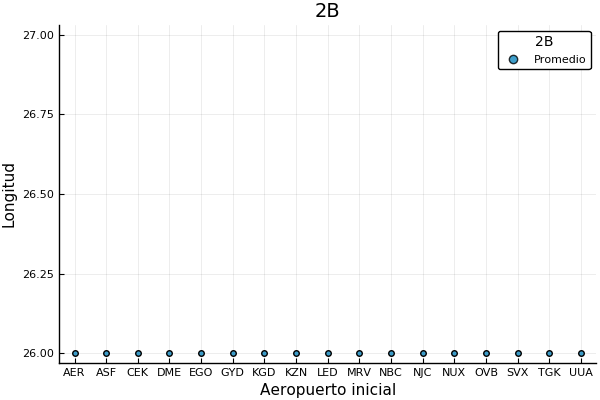

In [133]:
plot_av_length_vertex(caminata_M, "2B")

In [27]:
"""
    walk_layer_length(W::Array{Any,1})

Función que saca el promedio de longitud de caminata en la capa
"""
function walk_layer_length(W::Array{Any,1})
    
    x = walk_av_length(W)
    av = mean(x)
    
    return av
end

walk_layer_length

In [121]:
walk_layer_length(caminata_M)

26.0

### Frecuencia de visitas

In [28]:
"""
    freq_vertices_visits(W::Array{Any,1})

Función que hace un diccionario con frecuencias de visitas
"""
function freq_vertices_visits(W::Array{Any,1})
    
    dicc = [] #arreglo vacío
    
    nodos = length(W) #tamaño de caminatas
    iter = size(W[1], 1) #núm de iteraciones
    diccionario = 0
    
    #for i = n
    for i in 1:nodos #corro por todos los nodos
        for j in 1:iter #corro por las iteraciones
            diccionario = countmap(W[i][j, :]) #hago diccionario de freqs de cada caminata
            push!(dicc, diccionario) #guardo el diccionario en un arreglo vacío
        end
        
        diccionario = 0
    end
    return dicc
end

freq_vertices_visits

In [29]:
"""
    distrib_vertices_visits(W::Array{Any,1})

Función que crea un arreglo de arreglos con la distribución de frecuencia de visitas
"""
function distrib_vertices_visits(W::Array{Any,1})
    
    x = freq_vertices_visits(W) #diccionario de frecuencias
    l = length(W)
    f = 0
    frec_total = Array[] #zeros(Array, length(x)) #arreglo de ceros de tamaño núm dicc
    frec_nodo = zeros(Int64, l+1) #arreglo de nodos de tamaño núm nodos para get frec

    for i in 1:length(x) #corro por los nodos

        for j in 1:l+1 #corro por los nodos

            frec_nodo[j] = get(x[i], f, 0) #entrada j de freq nodo la cambio por la entrada j del dicc i
            f += 1
        end
        push!(frec_total, frec_nodo)
        
        f = 0
        frec_nodo = zeros(Int64, l+1)
        
    end
    
    return frec_total
end

distrib_vertices_visits

In [189]:
############# FUNCIÓN INÚTIL #############
"""
    plot_visit_freq(W::Array{Any,1})

Función que hace un heatmap de nodos en los que cae, cada renglón corresponde a una caminata
"""
function plot_visit_freq(W::Array{Any,1}) 
    
    pyplot()
    x = distrib_vertices_visits(W)
    h = transpose(hcat(x...))

    xs = [string("n", i) for i = 0:1:length(W)]
    ys = [string("rw", i) for i = 1:length(x)]
    z = h
    heatmap(xs, ys, z, aspect_ratio = 1)
end

plot_visit_freq

In [30]:
"""
    freq_vertex_visits(W::Array{Any,1}, n::Int64)

Función que hace un diccionario con frecuencias para un nodo inicial
"""
function freq_vertex_visits(W::Array{Any,1}, n::Int64) #puede ser más eficiente llamando la función anterior sin nodo
    
    dicc = [] #arreglo vacío
    
    nodos = length(W) #tamaño de caminatas
    iter = size(W[1], 1) #núm de iteraciones
    diccionario = 0
    
    for j in 1:iter #corro por las iteraciones
          
        diccionario = countmap(W[n][j, :]) #hago diccionario de freqs de cada caminata
          
        push!(dicc, diccionario) #guardo el diccionario en un arreglo vacío
          
    end
    
    return dicc
end

freq_vertex_visits

In [31]:
"""
    distrib_vertex_visits(W::Array{Any,1}, n::Int64)

Función que crea un arreglo de arreglos con la distribución de frecuencias de visitas de un nodo inicial
"""
function distrib_vertex_visits(W::Array{Any,1}, n::Int64)
    
    x = freq_vertex_visits(W, n) #diccionario de frecuencias
    nodos = length(W)
    f = 0
    frec_total = [] #zeros(Array, length(x)) #arreglo de ceros de tamaño núm dicc
    frec_nodo = zeros(Int64, nodos+1) #arreglo de nodos de tamaño núm nodos para get frec

    for i in 1:length(x) #corro por los nodos

        for j in 1:nodos+1 #corro por los nodos

            frec_nodo[j] = get(x[i], f, 0) #entrada j de freq nodo la cambio por la entrada j del dicc i
            
            f += 1
        end
        push!(frec_total, frec_nodo)
        
        f = 0
        frec_nodo = zeros(Int64, nodos+1)
        
    end
    
    return frec_total
end

distrib_vertex_visits

In [32]:
"""
    plot_visit_freq_vertex(W::Array{Any,1}, n::Int64)

Función que hace un heatmap de los nodos en los que cae, cada renglón corresponde a una caminata 
con cierto nodo inicial n.
"""
function plot_visit_freq_vertex(W::Array{Any,1}, n::Int64) #Con esta función se pierde la información de los nodos que caen en 0
    
    pyplot()
    
    x = distrib_vertex_visits(W, n)
    mat_completa = transpose(hcat(x...))    #Se covierte en matriz el arreglo
    mat = mat_completa[:, (2:end)]
    pasos = size(W[1], 2)-1
    
    xs = [nombres_multiplex]
    ys = [string("it", i) for i = 1:length(x)]
    z = mat
    heatmap(xs, ys, z, 
        title = "Frecuencia de visitas para v_{0} = $n",
        aspect_ratio = 1, 
        clims = (0, pasos), 
        xticks = :all,  
        xtickfont = font(8, "Courier"))
end

plot_visit_freq_vertex

In [33]:
"""
    distrib_av_visits(W::Array{Any, 1})

Función que hace una distribución de visitas por nodo inicial y muestra todos los nodos iniciales
"""
function distrib_av_visits(W::Array{Any, 1}) 
    
    nodos = length(W) #número de nodos
    iteracion = size(W[1],1)
    dicc = zeros(Float64, nodos, nodos+1) #matriz de ceros (nodos x nodos+1)
    
    for i in 1:nodos #(1 a 17)
        prom_conteos = counts(W[i], 0:nodos)/iteracion #hago diccionario con prom de freqs de cada nodo inicial
        #@show prom_conteos
        dicc[i, :] = prom_conteos 
    end

    dicc
end

distrib_av_visits

In [34]:
"""
    plot_freq_av_visits(W::Array{Any, 1})

Función que crea un diccionario con frecuencias por nodo inicial y muestra todos
"""
function plot_freq_av_visits(W::Array{Any, 1}, airline_code::String)
    
    pyplot()
    
    mat_completa = distrib_av_visits(W)
    mat = mat_completa[:, (2:end)] #desde la segunda columna para no tomar en cuenta los end-points
    
    xs = [nombres_multiplex]
    ys = [nombres_multiplex] #[string("v_0 ", i) for i = 1:length(W)]
    z = mat
    
    heatmap(xs, ys, z, 
        title = string("Frecuencia de visitas para ", airline_code),
        aspect_ratio = 1, 
        clims = (0, maximum(mat)), #MÁXIMO DEL MULTIPLEX GLOBAL/AEROLÍNEA MÁS GRANDE ¿?
        xticks = :all,
        yticks = :all,
        xtickfont = font(7, "Courier"),
        ytickfont = font(7, "Courier"),
        xlabel = "Visitas promedio",
        ylabel = "Aeropuerto inicial",
        xrotation = 50)
end

plot_freq_av_visits

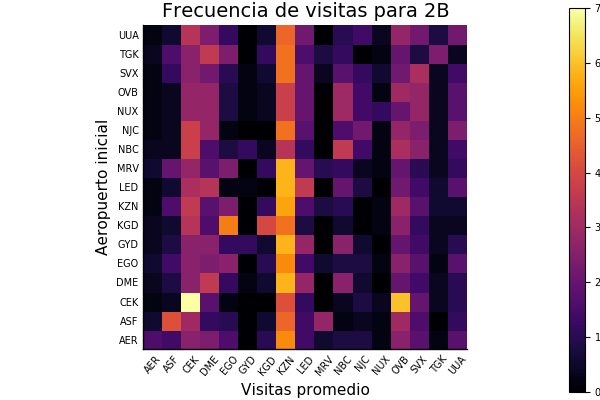

In [172]:
plot_freq_av_visits(caminata_M, "2B")

### Cobertura

In [35]:
"""
    coverage(W::Array{Any,1})

La función cobertura tiene como parámetro W que es un arreglo de arreglos.
Regresa el número de nodos diferentes a los que llega el caminante.
"""
function coverage(W::Array{Any,1}) 
    
    cobert = []
    
    v = length(W) #tamaño de la matriz, número de nodos
    x = visited_vertices(W)
    s = size(x[1], 1) #lo puedo sacar, para todos es el mismo. Es el número de iteraciones
    longz = zeros(Int64, s) #Arreglo de ceros de tamaño número de iteraciones
    
    for i in 1:v        
        for j in 1:s
            l = length(x[i][j])
            longz[j] = l
        end
        
        push!(cobert, longz)
        longz = zeros(Int64, s)
    end
    
    return cobert
end

coverage

In [36]:
"""
    vertex_coverage(W::Array{Any,1})

Da el promedio de cobertura la caminata por nodo inicial. 
"""
function vertex_coverage(W::Array{Any,1}) #Esta es la importante
    
    longitud = Array{Float64}(undef, 0)
    x = coverage(W)
    
    for i in 1:length(x)
        l = mean(x[i])
        push!(longitud, l)
    end
    
    longitud
end

vertex_coverage

In [122]:
vertex_coverage(caminata_M)

17-element Array{Float64,1}:
 10.8
 10.0
  9.0
  9.6
 11.0
 10.4
  8.8
  9.8
  9.4
 10.2
 10.4
 10.0
 10.8
 10.2
 10.0
  9.0
 10.2

In [37]:
"""
    plot_vertex_coverage(W::Array{Any, 1}, airline_code::String)

Función que grafica (scatter plot) del promedio por nodo inicial de caminatas
"""
function plot_vertex_coverage(W::Array{Any, 1}, airline_code::String)
    
    info = vertex_coverage(W)
    
    scatter(info, 
        color = "#0f87bf",
        alpha = 0.4, 
        title = string("Cobertura por nodo inicial ", airline_code), 
        xlabel = "Aeropuerto inicial", 
        ylabel = "Longitud", 
        xticks = (1:1:length(W), nombres_multiplex),
        legendtitle = airline_code,
        label = "Promedio",
        xrotation = 50)
    
end

plot_vertex_coverage

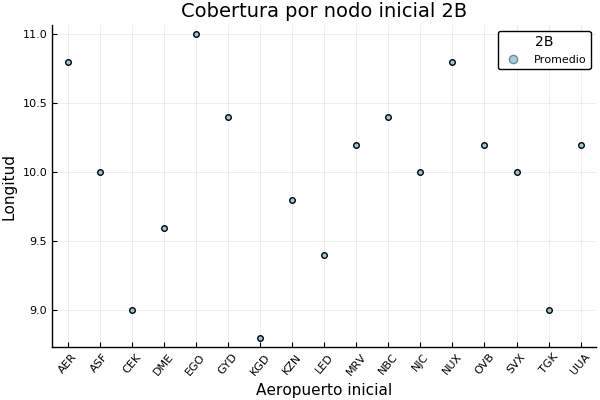

In [135]:
plot_vertex_coverage(caminata_M, "2B")

In [38]:
"""
    layer_coverage(W::Array{Any, 1})

Da el promedio de la longitud de las caminatas para todos los nodos, como un número.
"""
function layer_coverage(W::Array{Any, 1})
    x = vertex_coverage(W)
    promedio = mean(x)
    return promedio
end

layer_coverage

### Máximos y mínimos de longitud

In [39]:
"""
    max_length(W::Array{Any, 1})

Da la longitud máxima de cada iteración de cada nodo inicial.
"""
function max_length(W::Array{Any, 1})
    max = Array{Int64}(undef, 0)
    x = coverage(W)
    for i in 1:length(x)
        m = maximum(x[i])
        push!(max, m)
    end
    max
end

max_length

In [40]:
"""
    Max_length(W::Array{Any, 1})

Da la longitud máxima total.
"""
function Max_length(W::Array{Any, 1})
    x = max_length(W)
    m = maximum(x)
    return m
end

Max_length

In [41]:
"""
    av_max_length(W::Array{Any, 1})

Regresa el promedio de la longitud máxima de cada nodo inicial.
"""
function av_max_length(W::Array{Any, 1})
    x = max_length(W)
    prom = mean(x)
    return prom
end

av_max_length

In [42]:
"""
    min_length(W::Array{Any, 1})

Da la longitud mínima de cada iteración de cada nodo inicial.
"""
function min_length(W::Array{Any, 1})
    min = Array{Int64}(undef, 0)
    x = coverage(W)
    for i in 1:length(x)
        m = minimum(x[i])
        push!(min, m)
    end
    min
end

min_length

In [43]:
"""
    Min_length(W::Array{Any, 1})

Da la longitud mínima total.
"""
function Min_length(W::Array{Any, 1})
    x = min_length(W)
    m = minimum(x)
    return m
end

Min_length

In [44]:
"""
    av_min_length(W::Array{Any, 1})

Regresa el promedio de la longitud mínima de cada nodo inicial.
"""
function av_min_length(W::Array{Any, 1})
    x = min_length(W)
    prom = mean(x)
    return prom
end

av_min_length

### End-points

In [45]:
"""
    endpoints(W::Array{Any, 1})

Regresa un arreglo de arreglos que contiene los nodos en los que cae cada caminata y ya no puede salir.
"""
function endpoints(W::Array{Any, 1})
    
    x = visited_vertices(W)
    
    atractores = Array[] #Arreglo vacío que contenga a los atractores
    v = length(W) #tamaño de la matriz, número de nodos
    s = size(W[1], 1) #lo puedo sacar, para todos es el mismo. Es el número de iteraciones
    t = size(W[1], 2) #número de pasos +1
    atract = zeros(Int64, s) #Arreglo de ceros de tamaño número de iteraciones
    
    for i in 1:v        
        for j in 1:s
            if x[i][j, :][end][end] == 0
                at = x[i][j, :][end][end - 1]
                atract[j] = at
            else
                atract[j] = 0
            end
        end
        push!(atractores, atract)
        atract = zeros(Int64, s)
    end
    
    return atractores
end

endpoints

In [135]:
hholi =endpoints(caminata_M)

17-element Array{Array,1}:
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]

In [46]:
"""
   which_endpoints(M::Array{Int64,2})

Función que da el índice de los end-points.
"""
function which_endpoints(M::Array{Int64,2})
    deg = out_degree(M)
    ci = findall(iszero, deg)
    arr = Array{Int64}(undef, 0)
    for i in 1:length(ci)
        index = ci[1][2]
        push!(arr, index)
    end
    return arr
end

which_endpoints

In [90]:
"""
    freq_all_endpoints(W::Array{Any, 1})

Función con diccionarios de frecuencias de end-points
"""
function freq_all_endpoints(W::Array{Any, 1})
    
    info = endpoints(W)
    resu = []
    c = 0
    
    for i in 1:length(info)
    
        c = countmap(info[i])
        push!(resu, c)
        c = 0
    end
    return resu
end

freq_all_endpoints

In [96]:
freq_all_endpoints(caminata_M)

17-element Array{Any,1}:
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)

In [109]:
function distrib_all_endpoints(M::Array{Int64,2}, W::Array{Any, 1})
    
    info = freq_all_endpoints(W)
    endpts = which_endpoints(M)
    ######################################
    
    l = length(W) #num nodos iniciales
    e = length(endpts) 
    #@show l
    f = 0  #contador
    frec_total = Array[] #zeros(Array, length(x)) #arreglo de ceros de tamaño núm dicc
    frec_nodo = zeros(Int64, l+1) #arreglo de nodos de tamaño núm nodos para get frec

    for i in 1:length(info) #corro por los nodos

        for j in 1:l+1 #corro por los nodos

            frec_nodo[j] = get(info[i], f, 0) #entrada j de freq nodo la cambio por la entrada j del dicc i
            f += 1
        end
        push!(frec_total, frec_nodo)
        
        f = 0
        frec_nodo = zeros(Int64, l+1)
        
    end
    
    return frec_total
    
end

distrib_all_endpoints (generic function with 1 method)

In [110]:
distrib_all_endpoints(caminata_M)

l = 17


17-element Array{Array,1}:
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [147]:
out_degree_multiplex[15] = 0
out_degree_multiplex

1×17 Array{Int64,2}:
 1  2  2  4  2  1  1  7  3  1  4  2  1  2  0  1  3

In [161]:
which_endpoints(out_degree_multiplex)

1-element Array{Int64,1}:
 15

In [ ]:
#función que cambie los endpoints a nombres de aeropuertos

In [281]:
""" NOOOO
    plot_endpoints(W::Array{Any, 1}, airline_code::String)

Función que grafica la información de los endpoints por nodo inicial
"""
function plot_endpoints(W::Array{Any, 1}, airline_code::String) #No necesario y mal
    
    pyplot()
    
    info = endpoints(W)
    
    mat_completa = distrib_av_visits(W)
    mat = mat_completa[:, (2:end)] #desde la segunda columna para no tomar en cuenta los end-points
    
    xs = [nombres_multiplex]
    ys = [nombres_multiplex] #[string("v_0 ", i) for i = 1:length(W)]
    z = mat
    
    heatmap(xs, ys, z, 
        title = string("Frecuencia de visitas para ", airline_code),
        aspect_ratio = 1, 
        clims = (0, maximum(mat)), #MÁXIMO DEL MULTIPLEX GLOBAL/AEROLÍNEA MÁS GRANDE ¿?
        xticks = :all,
        yticks = :all,
        xtickfont = font(7, "Courier"),
        ytickfont = font(7, "Courier"),
        xlabel = "Visitas promedio",
        ylabel = "Aeropuerto inicial",
        xrotation = 50)
end

plot_endpoints

xs = ["AER", "ASF", "CEK", "DME", "EGO", "GYD", "KGD", "KZN", "LED", "MRV", "NBC", "NJC", "NUX", "OVB", "SVX", "TGK", "UUA"]
ys = [1, 2, 3, 4, 5]
z = [0, 0, 0, 0, 0]
xs = ["AER", "ASF", "CEK", "DME", "EGO", "GYD", "KGD", "KZN", "LED", "MRV", "NBC", "NJC", "NUX", "OVB", "SVX", "TGK", "UUA"]
ys = [1, 2, 3, 4, 5]
z = [0, 0, 0, 0, 0]
xs = ["AER", "ASF", "CEK", "DME", "EGO", "GYD", "KGD", "KZN", "LED", "MRV", "NBC", "NJC", "NUX", "OVB", "SVX", "TGK", "UUA"]
ys = [1, 2, 3, 4, 5]
z = [0, 0, 0, 0, 0]
xs = ["AER", "ASF", "CEK", "DME", "EGO", "GYD", "KGD", "KZN", "LED", "MRV", "NBC", "NJC", "NUX", "OVB", "SVX", "TGK", "UUA"]
ys = [1, 2, 3, 4, 5]
z = [0, 0, 0, 0, 0]
xs = ["AER", "ASF", "CEK", "DME", "EGO", "GYD", "KGD", "KZN", "LED", "MRV", "NBC", "NJC", "NUX", "OVB", "SVX", "TGK", "UUA"]
ys = [1, 2, 3, 4, 5]
z = [0, 0, 0, 0, 0]
xs = ["AER", "ASF", "CEK", "DME", "EGO", "GYD", "KGD", "KZN", "LED", "MRV", "NBC", "NJC", "NUX", "OVB", "SVX", "TGK", "UUA"]
ys = [1, 2, 3, 4, 5]
z = [0, 0, 0, 0, 0]
xs =

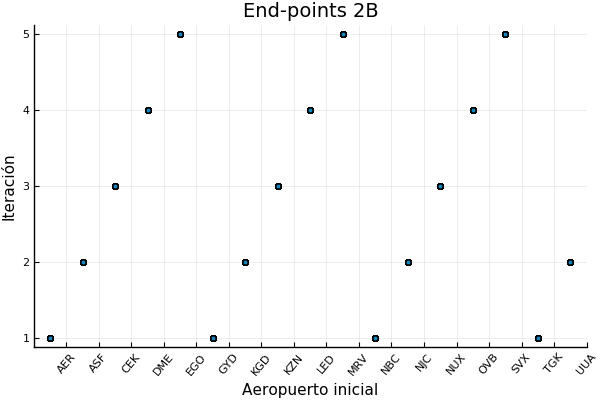

In [282]:
plot_endpoints(caminata_M, "2B")

In [48]:
"""
    av_vertex_endpoints(W::Array{Any, 1})

Función que calcula el promedio de endpoints por nodo
"""
function av_vertex_endpoints(W::Array{Any, 1}) 
    
    x = endpoints(W)
    atractores_prom = Array{Float64}(undef, 0) #Arreglo vacío que contenga a los atractores
    v = length(W) #tamaño de la matriz, número de nodos

    for i in 1:v        
        av = mean(x[i])
        push!(atractores_prom, av)
    end
    
    atractores_prom
end

av_vertex_endpoints

In [163]:
av_vertex_endpoints(caminata_M)

17-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

### Distribución de frecuencia de end-points

In [49]:
"""
    freq_endpoints(W::Array{Any, 1})

Función que da un diccionario con frecuencias
"""
function freq_endpoints(W::Array{Any, 1})
    freqs = []
    x = endpoints(W)
    v = length(W)
    
    for i in 1:v
        frec = countmap(x[i])
        push!(freqs, frec)
    end
    freqs
end

freq_endpoints

In [160]:
freq_endpoints(caminata_M)

17-element Array{Any,1}:
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)

In [50]:
"""
    distrib_endpoints(W::Array{Any, 1})

Función que saca la distribución de los endpoints para toda la capa
"""
function distrib_endpoints(W::Array{Any, 1})
    
    x = freq_endpoints(W)
    frec_total = zeros(Int64, length(W))
    frec_nodo = zeros(Int64, length(W))

    for i in 1:length(W)
        for j in 1:length(W)
            frec_nodo[j] = get(x[i], j, 0)
        end
        frec_total += frec_nodo
    end
    
    return frec_total
end

distrib_endpoints

In [161]:
distrib_endpoints(caminata_M)

17-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

### Gráficas de end-points

In [87]:
"""
    plot_vertex_endpoints(W::Array{Any, 1}, airline_code::String)

Función que grafica la información de los endpoints por nodo inicial
"""
function plot_vertex_endpoints(W::Array{Any, 1}, airline_code::String) #MAL
    
    info = distrib_endpoints(W) #endpoints por nodo inicial
    
    heatmap(xs, ys, z, 
        title = string("Frecuencia de visitas para ", airline_code),
        aspect_ratio = 1, 
        clims = (0, maximum(mat)), #MÁXIMO DEL MULTIPLEX GLOBAL/AEROLÍNEA MÁS GRANDE ¿?
        xticks = :all,
        yticks = :all,
        xtickfont = font(7, "Courier"),
        ytickfont = font(7, "Courier"),
        xlabel = "Visitas promedio",
        ylabel = "Aeropuerto inicial",
        xrotation = 50)
    
    scatter(info, 
        color = "#0f87bf",
        alpha = 0.4, 
        title = string("End-points por nodo inicial ", airline_code), 
        xlabel = "Aeropuerto inicial", 
        ylabel = "End-points", 
        xticks = (1:1:length(W), nombres_multiplex),
        legendtitle = airline_code,
        label = "Promedio",
        xrotation = 50)
end

plot_vertex_endpoints

In [134]:
distrib_endpts_M = @time distrib_endpoints(caminata_M)

  0.000410 seconds (1.52 k allocations: 161.016 KiB)


17-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [88]:
"""
    plot_layer_endpoints(W::Array{Any, 1})

Función que grafica la información de los endpoints en toda una capa(aerolínea)
"""
function plot_layer_endpoints(W::Array{Any, 1})
    
end

plot_layer_endpoints

### Distribución Betweenness

In [ ]:
"""
    plot_betweenness(W::Array{Any, 1}, airline_code::String)

Función que grafica (scatter plot) de la distribución de betweenness de los nodos.
"""
function plot_betweenness()
    
    
end


function plot_vertex_coverage(W::Array{Any, 1}, airline_code::String)
    
    info = vertex_coverage(W)
    
    scatter(info, 
        color = "#0f87bf",
        alpha = 0.4, 
        title = string("Cobertura por nodo inicial ", airline_code), 
        xlabel = "Aeropuerto inicial", 
        ylabel = "Longitud", 
        xticks = (1:1:length(W), nombres_multiplex),
        legendtitle = airline_code,
        label = "Promedio",
        xrotation = 50)
    
end

### Grafo

In [151]:
"""
    my_graph(M::Array{Int64,2}, airline_code::String)

Función que hace el grafo de la red aérea dirigida.
"""
function my_graph(M::Array{Int64,2}, airline_code::String)
    
    grafo = DiGraph(M)
    
end

my_graph

In [152]:
jh= my_graph(multiplex, "2B")

{17, 42} directed simple Int64 graph

### Plot Grafo

In [143]:
"""
    plot_net(M::Array{Int64,2}, airline_code::String)

Función que hace el grafo de la red aérea dirigida.
"""
function plot_net(M::Array{Int64,2}, airline_code::String)
    
    grafo = DiGraph(M)
    red = gplot(grafo)
    
    return red
    
end

plot_net

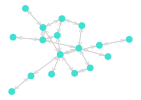

In [145]:
ih= plot_net(multiplex, "2B")

In [162]:
"""
    my_betweenness_centrality(M::Array{Int64,2}, airline_code::String)

Función que hace el grafo de la red aérea dirigida.
"""
function my_betweenness_centrality(M::Array{Int64,2}, airline_code::String)
    
    grafo = DiGraph(M)
    res = betweenness_centrality(grafo)
    
    return res
    
end

my_betweenness_centrality

In [153]:
ggg= betweenness_centrality(jh)

17-element Array{Float64,1}:
 0.0                 
 0.125               
 0.033333333333333326
 0.2                 
 0.125               
 0.0                 
 0.0                 
 0.6305555555555554  
 0.075               
 0.0                 
 0.16388888888888886 
 0.025               
 0.0                 
 0.016666666666666666
 0.3166666666666667  
 0.0                 
 0.030555555555555555

In [154]:
sort(ggg)

17-element Array{Float64,1}:
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.0                 
 0.016666666666666666
 0.025               
 0.030555555555555555
 0.033333333333333326
 0.075               
 0.125               
 0.125               
 0.16388888888888886 
 0.2                 
 0.3166666666666667  
 0.6305555555555554  

In [136]:
"""
    plot_betweenness(M::Array{Int64,2}, airline_code::String)

Función que hace el grafo de la red aérea dirigida.
"""
function plot_betweenness(M::Array{Int64,2}, airline_code::String)
    
    aerolinea_matriz = string(airline_code, "_matriz_du.csv")
    nombres_multiplex = airport_names("/Users/yuriko/Documents/UNAM/Tesis_Lic/data/aerolineas_matrices/$aerolinea_matriz")
    
    grafo = DiGraph(M)
    between = betweenness_centrality(grafo)
    orden = sort(between)
    
    xs = [nombres_multiplex]
    
    return red
    
end

search: betweenness_centrality



```
betweenness_centrality(g[, vs])
betweenness_centrality(g, k)
```

Calculate the [betweenness centrality](https://en.wikipedia.org/wiki/Centrality#Betweenness_centrality) of a graph `g` across all vertices, a specified subset of vertices `vs`, or a random subset of `k` vertices. Return a vector representing the centrality calculated for each node in `g`.

### Optional Arguments

  * `normalize=true`: If true, normalize the betweenness values by the

total number of possible distinct paths between all pairs in the graphs. For an undirected graph, this number is $\frac{(|V|-1)(|V|-2)}{2}$ and for a directed graph, ${(|V|-1)(|V|-2)}$.

  * `endpoints=false`: If true, include endpoints in the shortest path count.

Betweenness centrality is defined as: $bc(v) = \frac{1}{\mathcal{N}} \sum_{s \neq t \neq v} \frac{\sigma_{st}(v)}{\sigma_{st}}$.

### References

  * Brandes 2001 & Brandes 2008

# Examples

```jldoctest
julia> using LightGraphs

julia> betweenness_centrality(StarGraph(3))
3-element Array{Float64,1}:
 1.0
 0.0
 0.0

julia> betweenness_centrality(PathGraph(4))
4-element Array{Float64,1}:
 0.0
 0.6666666666666666
 0.6666666666666666
 0.0
```


In [296]:
betweenness_centrality(g)

34-element Array{Float64,1}:
 0.4376352813852815   
 0.053936688311688304 
 0.14365680615680618  
 0.011909271284271283 
 0.0006313131313131313
 0.02998737373737374  
 0.029987373737373736 
 0.0                  
 0.055926827801827804 
 0.0008477633477633478
 0.0006313131313131313
 0.0                  
 0.0                  
 ⋮                    
 0.0                  
 0.017613636363636363 
 0.0022095959595959595
 0.0038404882154882154
 0.0                  
 0.02233345358345358  
 0.0017947330447330447
 0.0029220779220779218
 0.014411976911976907 
 0.13827561327561325  
 0.14524711399711396  
 0.30407497594997596  

## Datos


### Aerolínea 2B

In [127]:
lista_aerolineas = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/data/aerolineas_matrices/lista_aerolineas.csv", ',', String)
airline_code = lista_aerolineas[2]

"2B"

In [128]:
typeof(airline_code)

String

In [52]:
aerolinea_matriz = string(airline_code, "_matriz_du.csv")
multiplex = import_matrix("data/aerolineas_matrices/$aerolinea_matriz")

17×17 Array{Int64,2}:
 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  1  1
 0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  0  0  0  1  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0  1
 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  1  0  0  1  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  1  0  0  1  1  1  1  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  1  0  0  1  0  0  0  0  0

In [134]:
data_names_multiplex = airport_names("data/aerolineas_matrices/$aerolinea_matriz")

17-element Array{String,1}:
 "AER"
 "ASF"
 "CEK"
 "DME"
 "EGO"
 "GYD"
 "KGD"
 "KZN"
 "LED"
 "MRV"
 "NBC"
 "NJC"
 "NUX"
 "OVB"
 "SVX"
 "TGK"
 "UUA"

## Distribuciones de grado

### Multiplex Global

#### Grado de entrada

In [54]:
in_degree_multiplex = in_degree(multiplex)

17×1 Array{Int64,2}:
 1
 2
 2
 4
 2
 1
 1
 7
 3
 1
 4
 2
 1
 2
 5
 1
 3

In [55]:
distrib_in_multiplex = distrib_in_degree(multiplex)

7-element Array{Int64,1}:
 6
 5
 2
 2
 1
 0
 1

┌ Info: Recompiling stale cache file /Users/yuriko/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


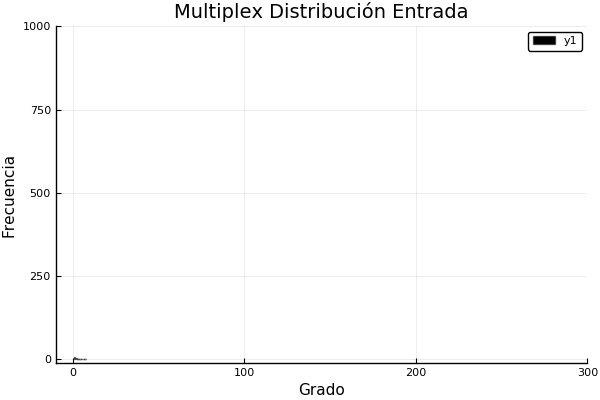

In [94]:
in_M = plot_distrib(multiplex, "in", "Multiplex Distribución Entrada", "black")

#### Grado de salida

In [56]:
out_degree_multiplex = out_degree(multiplex)

1×17 Array{Int64,2}:
 1  2  2  4  2  1  1  7  3  1  4  2  1  2  5  1  3

In [57]:
distrib_out_multiplex = distrib_out_degree(multiplex)

7-element Array{Int64,1}:
 6
 5
 2
 2
 1
 0
 1

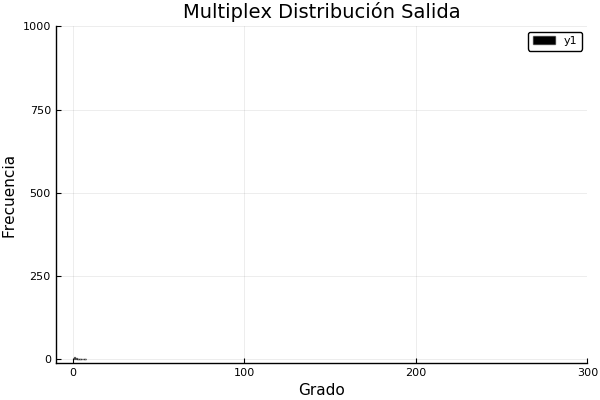

In [97]:
out_M = plot_distrib(multiplex, "out", "Multiplex Distribución Salida", "black")

## Vecinos

### Multiplex global

In [58]:
vecinos_M = @time neighbours(multiplex)

  0.106856 seconds (205.86 k allocations: 9.880 MiB)


17-element Array{Any,1}:
 [8]                   
 [8, 10]               
 [8, 14]               
 [8, 11, 16, 17]       
 [7, 8]                
 [11]                  
 [5]                   
 [1, 2, 3, 4, 5, 9, 15]
 [8, 11, 17]           
 [2]                   
 [4, 6, 9, 15]         
 [15, 17]              
 [15]                  
 [3, 15]               
 [8, 11, 12, 13, 14]   
 [4]                   
 [4, 9, 12]            

## Caminatas aleatorias

### Multiplex

In [59]:
caminata_M = @time random_walk(multiplex, 25, 5) #nuevo

  0.206265 seconds (422.50 k allocations: 21.646 MiB, 4.24% gc time)


17-element Array{Any,1}:
 [1 8 … 8 1; 1 8 … 4 8; … ; 1 8 … 4 8; 1 8 … 14 3]           
 [2 10 … 15 12; 2 10 … 4 8; … ; 2 10 … 4 8; 2 10 … 9 17]     
 [3 14 … 15 12; 3 14 … 4 8; … ; 3 14 … 4 8; 3 14 … 14 3]     
 [4 11 … 15 12; 4 11 … 4 8; … ; 4 11 … 4 8; 4 11 … 14 3]     
 [5 8 … 8 1; 5 8 … 4 8; … ; 5 8 … 4 8; 5 8 … 14 3]           
 [6 11 … 15 12; 6 11 … 4 8; … ; 6 11 … 4 8; 6 11 … 14 3]     
 [7 5 … 8 1; 7 5 … 8 9; … ; 7 5 … 14 3; 7 5 … 14 3]          
 [8 9 … 8 1; 8 9 … 8 9; … ; 8 4 … 14 3; 8 5 … 14 3]          
 [9 17 … 15 12; 9 8 … 4 8; … ; 9 11 … 4 8; 9 8 … 14 3]       
 [10 2 … 8 1; 10 2 … 8 9; … ; 10 2 … 14 3; 10 2 … 14 3]      
 [11 6 … 8 1; 11 6 … 4 8; … ; 11 6 … 14 3; 11 6 … 14 3]      
 [12 17 … 15 12; 12 17 … 4 8; … ; 12 17 … 14 3; 12 17 … 14 3]
 [13 15 … 8 1; 13 15 … 4 8; … ; 13 15 … 14 3; 13 15 … 14 3]  
 [14 15 … 8 1; 14 15 … 4 8; … ; 14 15 … 14 3; 14 15 … 14 3]  
 [15 11 … 15 12; 15 13 … 4 8; … ; 15 11 … 4 8; 15 13 … 14 3] 
 [16 4 … 8 1; 16 4 … 8 9; … ; 16 4 … 14 3; 16

## Longitud de todas las iteraciones de caminatas 

In [60]:
li_M = @time walk_length(caminata_M)

  0.101993 seconds (201.68 k allocations: 9.671 MiB)


17-element Array{Array,1}:
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]
 [26, 26, 26, 26, 26]

## Longitud promedio de las iteraciones de caminatas de cada nodo inicial

In [61]:
lpn_M = @time walk_av_length(caminata_M)

  0.091184 seconds (196.51 k allocations: 10.076 MiB)


17-element Array{Float64,1}:
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0
 26.0

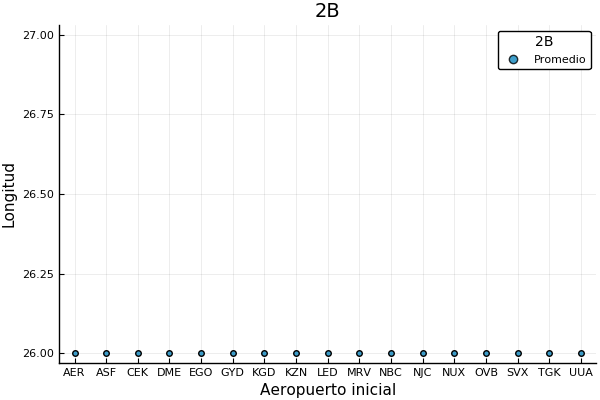

In [102]:
plot_av_length_vertex(caminata_M, "2B")

## Longitud promedio de caminatas por capa

In [62]:
wl_M = @time walk_layer_length(caminata_M)

  0.047857 seconds (103.48 k allocations: 5.260 MiB)


26.0

## Nodos visitados específicamente

In [63]:
#No lo corro ahora para que no se tarde tanto
nv_M = @time visited_vertices(caminata_M)

  0.091006 seconds (131.57 k allocations: 6.807 MiB)


17-element Array{Any,1}:
 Any[[1, 8, 4, 17, 12, 15, 11, 9, 2, 5, 7], [1, 8, 4, 17, 11, 9, 15, 3, 14], [1, 8, 2, 10, 5, 7, 15, 12, 17, 9, 11, 4], [1, 8, 2, 10, 15, 14, 13, 3, 9, 17, 4], [1, 8, 9, 17, 12, 15, 4, 2, 16, 3, 14]]     
 Any[[2, 10, 8, 3, 9, 4, 17, 14, 15, 12], [2, 10, 8, 1, 4, 15, 3, 14], [2, 10, 8, 5, 7, 1, 15, 12, 17, 9, 11, 4], [2, 10, 8, 15, 14, 13, 3, 9, 17, 4], [2, 10, 8, 9, 17, 4, 1, 3, 14, 15]]                  
 Any[[3, 14, 15, 8, 9, 2, 4, 17, 12], [3, 14, 8, 1, 4, 15], [3, 14, 15, 12, 17, 9, 11, 4, 8, 16, 5], [3, 14, 8, 15, 13, 9, 17, 4], [3, 14, 15, 13, 12, 17, 9, 8, 2, 4, 16]]                                 
 Any[[4, 11, 9, 8, 15, 3, 14, 2, 17, 12], [4, 11, 9, 8, 1, 15, 3, 14], [4, 11, 9, 8, 5, 2, 7, 1, 15, 12, 17], [4, 11, 9, 8, 16, 2, 6, 17], [4, 11, 9, 17, 12, 15, 8, 2, 16, 3, 14]]                         
 Any[[5, 8, 4, 17, 12, 15, 11, 9, 2, 7, 1], [5, 8, 4, 17, 11, 9, 1, 15, 3, 14], [5, 8, 2, 10, 7, 1, 15, 12, 17, 9, 11, 4], [5, 8, 2, 10, 15, 14, 13, 3, 9, 

In [64]:
@time walk_names(caminata_M, "2B", 2)

  1.993079 seconds (14.11 M allocations: 528.907 MiB, 29.13% gc time)


5×26 Array{Union{Nothing, String},2}:
 "ASF"  "MRV"  "ASF"  "MRV"  "ASF"  …  "OVB"  "CEK"  "OVB"  "SVX"  "NJC"
 "ASF"  "MRV"  "ASF"  "MRV"  "ASF"     "OVB"  "CEK"  "KZN"  "DME"  "KZN"
 "ASF"  "MRV"  "ASF"  "MRV"  "ASF"     "NJC"  "UUA"  "LED"  "NBC"  "DME"
 "ASF"  "MRV"  "ASF"  "MRV"  "ASF"     "KZN"  "LED"  "UUA"  "DME"  "KZN"
 "ASF"  "MRV"  "ASF"  "MRV"  "ASF"     "KZN"  "ASF"  "KZN"  "LED"  "UUA"

In [65]:
for i in 1:length(caminata_M)
    cam = @time walk_names(caminata_M, "2B", i)
    return cam
end

  1.505426 seconds (12.91 M allocations: 468.412 MiB, 56.04% gc time)


5×26 Array{Union{Nothing, String},2}:
 "AER"  "KZN"  "DME"  "UUA"  "NJC"  …  "EGO"  "KGD"  "EGO"  "KZN"  "AER"
 "AER"  "KZN"  "DME"  "UUA"  "DME"     "OVB"  "CEK"  "KZN"  "DME"  "KZN"
 "AER"  "KZN"  "ASF"  "MRV"  "ASF"     "NJC"  "UUA"  "LED"  "NBC"  "DME"
 "AER"  "KZN"  "ASF"  "MRV"  "ASF"     "KZN"  "LED"  "UUA"  "DME"  "KZN"
 "AER"  "KZN"  "LED"  "UUA"  "NJC"     "CEK"  "OVB"  "CEK"  "OVB"  "CEK"

## Frecuencia de visitas

In [66]:
freq_visit_M = @time freq_vertices_visits(caminata_M)

  1.136361 seconds (3.37 M allocations: 177.305 MiB, 6.38% gc time)


85-element Array{Any,1}:
 Dict(2=>1,11=>2,7=>2,9=>2,17=>4,8=>4,4=>3,5=>3,15=>1,12=>2…) 
 Dict(4=>4,9=>1,14=>4,3=>5,17=>1,11=>1,8=>7,15=>1,1=>2)       
 Dict(2=>3,11=>1,7=>3,9=>1,10=>2,17=>1,8=>5,4=>1,5=>5,15=>1…) 
 Dict(2=>2,9=>1,10=>1,17=>1,8=>4,4=>1,3=>4,13=>1,14=>6,15=>4…)
 Dict(2=>1,16=>1,9=>2,17=>2,8=>6,4=>3,3=>4,14=>3,15=>2,12=>1…)
 Dict(4=>1,9=>2,10=>4,14=>2,2=>6,3=>3,17=>1,8=>5,15=>1,12=>1…)
 Dict(4=>2,14=>4,10=>3,2=>4,3=>5,8=>6,15=>1,1=>1)             
 Dict(2=>4,11=>1,7=>3,9=>1,10=>3,17=>1,8=>4,4=>1,5=>5,15=>1…) 
 Dict(4=>1,9=>1,10=>2,13=>1,2=>3,3=>4,14=>6,17=>1,8=>3,15=>4…)
 Dict(4=>1,9=>3,10=>2,14=>3,2=>4,3=>3,17=>3,8=>5,15=>1,1=>1…) 
 Dict(4=>1,9=>2,14=>6,2=>1,3=>7,17=>1,8=>5,15=>2,12=>1)       
 Dict(4=>2,14=>7,3=>9,8=>6,15=>1,1=>1)                        
 Dict(16=>1,11=>2,9=>2,17=>1,8=>4,4=>3,3=>6,5=>1,14=>4,15=>1…)
 ⋮                                                            
 Dict(4=>5,9=>5,2=>1,16=>1,17=>1,11=>6,8=>5,15=>1,6=>1)       
 Dict(2=>1,16=>1,9=>1,17=>4,8=

In [67]:
distrib_visit_M = @time distrib_vertices_visits(caminata_M)

  0.032089 seconds (24.74 k allocations: 7.354 MiB)


85-element Array{Array,1}:
 [0, 2, 1, 0, 3, 3, 0, 2, 4, 2, 0, 2, 2, 0, 0, 1, 0, 4]
 [0, 2, 0, 5, 4, 0, 0, 0, 7, 1, 0, 1, 0, 0, 4, 1, 0, 1]
 [0, 2, 3, 0, 1, 5, 0, 3, 5, 1, 2, 1, 1, 0, 0, 1, 0, 1]
 [0, 1, 2, 4, 1, 0, 0, 0, 4, 1, 1, 0, 0, 1, 6, 4, 0, 1]
 [0, 1, 1, 4, 3, 0, 0, 0, 6, 2, 0, 0, 1, 0, 3, 2, 1, 2]
 [0, 0, 6, 3, 1, 0, 0, 0, 5, 2, 4, 0, 1, 0, 2, 1, 0, 1]
 [0, 1, 4, 5, 2, 0, 0, 0, 6, 0, 3, 0, 0, 0, 4, 1, 0, 0]
 [0, 1, 4, 0, 1, 5, 0, 3, 4, 1, 3, 1, 1, 0, 0, 1, 0, 1]
 [0, 0, 3, 4, 1, 0, 0, 0, 3, 1, 2, 0, 0, 1, 6, 4, 0, 1]
 [0, 1, 4, 3, 1, 0, 0, 0, 5, 3, 2, 0, 0, 0, 3, 1, 0, 3]
 [0, 0, 1, 7, 1, 0, 0, 0, 5, 2, 0, 0, 1, 0, 6, 2, 0, 1]
 [0, 1, 0, 9, 2, 0, 0, 0, 6, 0, 0, 0, 0, 0, 7, 1, 0, 0]
 [0, 0, 0, 6, 3, 1, 0, 0, 4, 2, 0, 2, 1, 0, 4, 1, 1, 1]
 ⋮                                                     
 [0, 0, 1, 0, 5, 0, 1, 0, 5, 5, 0, 6, 0, 0, 0, 1, 1, 1]
 [0, 0, 1, 4, 3, 0, 0, 0, 3, 1, 0, 0, 3, 1, 3, 2, 1, 4]
 [0, 2, 1, 0, 3, 6, 0, 3, 7, 1, 0, 0, 0, 0, 0, 0, 2, 1]
 [0, 0, 1, 3, 2, 5, 0

In [68]:
plot_visit_freq(caminata_M);

UndefVarError: UndefVarError: plot_visit_freq not defined

In [69]:
freq_vertex_visits(caminata_M, 1)

5-element Array{Any,1}:
 Dict(2=>1,11=>2,7=>2,9=>2,17=>4,8=>4,4=>3,5=>3,15=>1,12=>2…) 
 Dict(4=>4,9=>1,14=>4,3=>5,17=>1,11=>1,8=>7,15=>1,1=>2)       
 Dict(2=>3,11=>1,7=>3,9=>1,10=>2,17=>1,8=>5,4=>1,5=>5,15=>1…) 
 Dict(2=>2,9=>1,10=>1,17=>1,8=>4,4=>1,3=>4,13=>1,14=>6,15=>4…)
 Dict(2=>1,16=>1,9=>2,17=>2,8=>6,4=>3,3=>4,14=>3,15=>2,12=>1…)

In [70]:
distrib_vertex_visits(caminata_M, 1)

5-element Array{Any,1}:
 [0, 2, 1, 0, 3, 3, 0, 2, 4, 2, 0, 2, 2, 0, 0, 1, 0, 4]
 [0, 2, 0, 5, 4, 0, 0, 0, 7, 1, 0, 1, 0, 0, 4, 1, 0, 1]
 [0, 2, 3, 0, 1, 5, 0, 3, 5, 1, 2, 1, 1, 0, 0, 1, 0, 1]
 [0, 1, 2, 4, 1, 0, 0, 0, 4, 1, 1, 0, 0, 1, 6, 4, 0, 1]
 [0, 1, 1, 4, 3, 0, 0, 0, 6, 2, 0, 0, 1, 0, 3, 2, 1, 2]

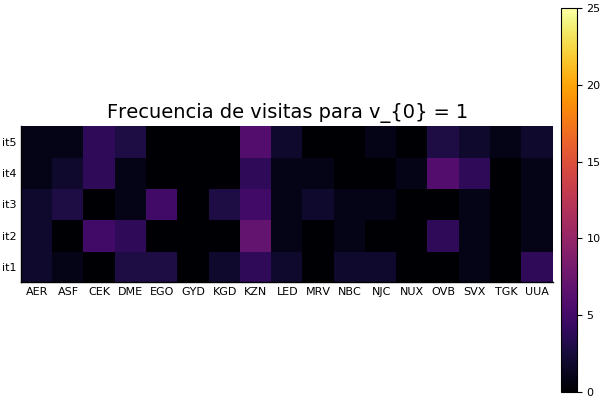

In [71]:
plot_visit_freq_vertex(caminata_M, 1)

In [72]:
distrib_prom_M = @time distrib_av_visits(caminata_M)

  0.249985 seconds (506.42 k allocations: 25.682 MiB, 40.22% gc time)


17×18 Array{Float64,2}:
 0.0  1.6  1.4  2.6  2.4  1.6  0.0  1.0  …  0.8  0.8  0.2  2.6  1.8  0.2  1.8
 0.0  0.6  4.2  3.0  1.2  1.0  0.0  0.6     0.2  0.4  0.2  3.0  1.6  0.0  1.2
 0.0  0.2  0.4  7.0  1.8  0.2  0.0  0.0     0.4  0.8  0.4  6.0  2.0  0.4  1.0
 0.0  0.4  0.8  2.6  3.6  1.2  0.2  0.6     2.6  0.6  0.0  2.0  1.4  0.4  1.0
 0.0  0.6  1.4  2.6  2.4  2.6  0.0  1.0     0.8  0.8  0.2  2.6  1.8  0.2  1.8
 0.0  0.4  0.8  2.6  2.6  1.2  1.2  0.6  …  2.6  0.6  0.0  2.0  1.4  0.4  1.0
 0.0  0.4  0.6  3.4  1.6  5.0  0.0  4.0     0.6  0.0  0.2  2.6  1.2  0.4  0.4
 0.0  0.2  1.6  3.6  1.8  2.4  0.0  1.2     1.0  0.0  0.2  3.0  1.8  0.6  0.6
 0.0  0.2  0.6  3.2  3.4  0.2  0.2  0.0     2.0  0.8  0.0  2.2  1.4  0.6  1.8
 0.0  0.6  2.0  2.8  1.8  2.4  0.0  1.2     1.2  0.4  0.2  2.0  1.0  0.4  1.2
 0.0  0.4  0.4  3.8  1.6  0.8  1.2  0.4  …  3.6  1.4  0.2  3.2  2.6  0.4  1.4
 0.0  0.2  0.4  3.8  2.8  0.2  0.0  0.0     1.6  2.2  0.2  2.8  2.4  0.4  2.4
 0.0  0.2  0.4  2.8  2.8  0.8  0.2  0.4 

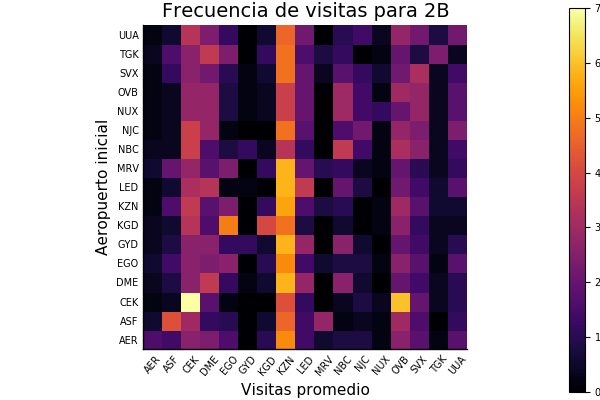

In [73]:
plot_freq_av_visits(caminata_M, "2B")

## Cobertura (nodos distintos)

In [74]:
cobi_M = @time coverage(caminata_M)

  0.054129 seconds (33.50 k allocations: 1.683 MiB)


17-element Array{Any,1}:
 [11, 9, 12, 11, 11] 
 [10, 8, 12, 10, 10] 
 [9, 6, 11, 8, 11]   
 [10, 8, 11, 8, 11]  
 [11, 10, 12, 11, 11]
 [11, 9, 12, 8, 12]  
 [8, 8, 7, 10, 11]   
 [10, 9, 10, 9, 11]  
 [9, 9, 11, 8, 10]   
 [9, 9, 11, 12, 10]  
 [10, 10, 11, 11, 10]
 [9, 10, 11, 10, 10] 
 [12, 11, 11, 10, 10]
 [12, 10, 10, 10, 9] 
 [10, 8, 12, 9, 11]  
 [9, 10, 9, 9, 8]    
 [10, 11, 11, 10, 9] 

## Cobertura promedio de las caminatas de cada aeropuerto inicial

In [75]:
cobs_M = @time vertex_coverage(caminata_M)

  0.014752 seconds (20.02 k allocations: 1.133 MiB)


17-element Array{Float64,1}:
 10.8
 10.0
  9.0
  9.6
 11.0
 10.4
  8.8
  9.8
  9.4
 10.2
 10.4
 10.0
 10.8
 10.2
 10.0
  9.0
 10.2

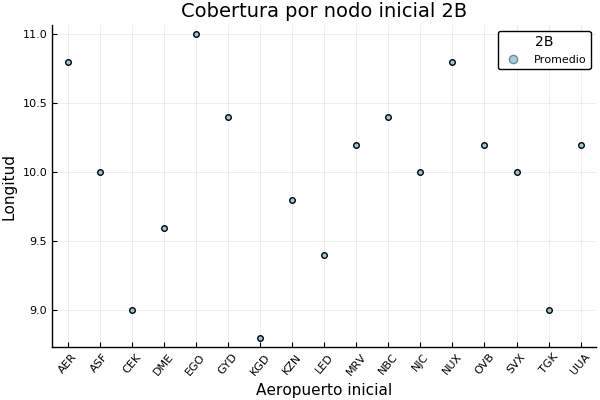

In [76]:
plot_vertex_coverage(caminata_M, "2B")

## Cobertura promedio

In [77]:
cobp_M = @time layer_coverage(caminata_M)

  0.006116 seconds (2.19 k allocations: 188.180 KiB)


9.976470588235294

## Longitudes máximas de caminatas

In [78]:
lmax_M = @time max_length(caminata_M)

  0.041272 seconds (50.65 k allocations: 2.749 MiB)


17-element Array{Int64,1}:
 12
 12
 11
 11
 12
 12
 11
 11
 11
 12
 11
 11
 12
 12
 12
 10
 11

In [79]:
lMax_M = @time Max_length(caminata_M)

  0.004638 seconds (2.24 k allocations: 190.332 KiB)


12

In [80]:
lavmax_M = @time av_max_length(caminata_M)

  0.008147 seconds (2.18 k allocations: 187.961 KiB)


11.411764705882353

## Longitudes mínimas de caminatas

In [81]:
lmin_M = @time min_length(caminata_M)

  0.037918 seconds (55.80 k allocations: 3.013 MiB)


17-element Array{Int64,1}:
  9
  8
  6
  8
 10
  8
  7
  9
  8
  9
 10
  9
 10
  9
  8
  8
  9

In [82]:
lMin_M = @time Min_length(caminata_M)

  0.004724 seconds (2.24 k allocations: 190.364 KiB)


6

In [83]:
lavmin_M = @time av_min_length(caminata_M)

  0.005597 seconds (2.18 k allocations: 187.914 KiB)


8.529411764705882

## Endpoints

In [84]:
endpts_M = @time endpoints(caminata_M)

  0.029329 seconds (22.83 k allocations: 1.219 MiB)


17-element Array{Array,1}:
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]

In [85]:
av_endpts_M = @time av_vertex_endpoints(caminata_M)

  0.013555 seconds (17.49 k allocations: 1020.651 KiB)


17-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [86]:
distrib_endpts_M = @time distrib_endpoints(caminata_M)

  0.252684 seconds (722.81 k allocations: 35.841 MiB, 8.82% gc time)


17-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [88]:
which_endpoints_M = @time which_endpoints(multiplex)

  0.121154 seconds (193.36 k allocations: 9.262 MiB, 9.28% gc time)


0-element Array{Int64,1}

In [91]:
freq_all_endpoints_M = @time freq_all_endpoints(caminata_M)

  0.016605 seconds (15.65 k allocations: 888.783 KiB)


17-element Array{Any,1}:
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)
 Dict(0=>5)

In [141]:
#Falta función plot con nombres